This notebook defines and tests two equivalent neural net models, one built on top of NumPy "from scratch", the other running on TensorFlow.

**This comparison is just a fun learning exercise, NOT a benchmark! Use TensorFlow.**

Scroll down for charts.

### Models

In [5]:
import numpy as np
import tensorflow as tf


def numpy_classifier(features, classes, hidden, learning_rate=0.35):
    """
    Multi-label classifier using a simple neural net model running
    on top of numpy.

    Arguments:
        features  -- input dimensions
        classes   -- number of output classes
        hidden    -- number of units in hidden layer (See below)

    Return (train, predict, loss) callables.

    Model consists of one sigmoid layer, one softmax layer,
    and is trained to minimize cross entropy:

    cross_entropy(y, softmax(sigmoid(x*W1 + b2)*W2 + b2));

    where x is an input example, y is the ground truth, and
    W1, b1, W2, b2 are model weights.
    """

    # Initialize weights
    W1 = np.random.rand(features, hidden) * 1e-5
    b1 = np.random.rand(hidden) * 1e-5
    W2 = np.random.rand(hidden, classes) * 1e-5
    b2 = np.random.rand(classes) * 1e-5

    def sigmoid(x, derived=False):
        result = 1.0 / (1 + np.exp(-1 * x))
        if derived:
            result = result * (1.0 - result)
        return result

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x))

    def predict(x):
        """
        Do forward prop for a list of inputs.
        """
        z2 = np.matmul(x, W1) + b1
        z3 = np.matmul(np.apply_along_axis(sigmoid, 1, z2), W2) + b2
        assert z3.shape == (len(x), classes)
        return np.apply_along_axis(softmax, 1, z3)

    def gradient(x, y):
        """
        Compute weight gradients for a list of training pairs.

        Arguments:
            x -- input
            y -- ground truth

        Return list (W1, b1, W2, b2) weight gradients tuples.
        """
        # Forward prop
        z2 = np.matmul(x, W1) + b1
        a2 = np.apply_along_axis(sigmoid, 1, z2)
        assert a2.shape == (len(x), hidden)
        z3 = np.matmul(a2, W2) + b2
        assert z3.shape == (len(x), classes)
        y_pred = np.apply_along_axis(softmax, 1, z3)

        # Backprop
        # - Derivative of loss function (cross_entropy(softmax(T); y))
        #   w.r.t. softmax input T.
        err_softmax = y_pred - y
        err_a2 = np.matmul(err_softmax, W2.T)
        # - Derivative of loss function w.r.t. to inputs of hidden layer.
        err_hidden = [sigmoid(z, derived=True) * err
                      for z, err in zip(z2, err_a2)]

        # Weight gradients
        grad_W2 = np.matmul(np.expand_dims(err_softmax, 2),
                            np.expand_dims(a2, 1))
        grad_W1 = np.matmul(np.expand_dims(err_hidden, 2),
                            np.expand_dims(x, 1))
        assert grad_W2.shape == (len(x),) + W2.T.shape
        assert grad_W1.shape == (len(x),) + W1.T.shape
        return grad_W1, err_hidden, grad_W2, err_softmax

    def cross_entropy(p, q):
        return (-1.0 * (p * np.log(q)))

    def loss(x, y):
        """
        Compute average cross entropy loss for a list of examples.
        """
        return np.average([cross_entropy(yy, yp)
                           for yy, yp in zip(y, predict(x))])

    def train(x, y):
        """
        Perform a single training step using a batch of training examples.
        """
        # Compute average gradients for batch
        delta = tuple(np.average(g, axis=0).T for g in gradient(x, y))
        delta_W1, delta_b1, delta_W2, delta_b2 = delta
        # Update weights
        nonlocal W1, b1, W2, b2
        W1 -= delta_W1 * learning_rate
        b1 -= delta_b1 * learning_rate
        W2 -= delta_W2 * learning_rate
        b2 -= delta_b2 * learning_rate

    return train, predict, loss


tf_session = tf.InteractiveSession()


def tensorflow_classifier(features, classes, hidden, learning_rate=0.4):
    """
    Equivalent of numpy_classifier, but on TensorFlow.

    Arguments:
        features  -- input dimensions
        classes   -- number of output classes
        hidden    -- number of units in hidden layer

    Return (train, predict, loss) callables.
    """

    # Placeholders
    x_input = tf.placeholder(tf.float32, [None, features])
    y_truth = tf.placeholder(tf.float32, [None, classes])

    # Weights
    W1 = tf.Variable(tf.random_uniform([features, hidden]), [-1e-5, 1e-5])
    b1 = tf.Variable(tf.random_uniform([hidden]), [-1e-5, 1e-5])
    W2 = tf.Variable(tf.random_uniform([hidden, classes]), [-1e-5, 1e-5])
    b2 = tf.Variable(tf.random_uniform([classes]), [-1e-5, 1e-5])

    # Layers
    hidden = tf.nn.sigmoid(tf.matmul(x_input, W1) + b1)
    y_pred = tf.nn.softmax(tf.matmul(hidden, W2) + b2)

    # Train
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_truth * tf.log(y_pred),
                                                  reduction_indices=[1]))
    train_step = (tf.train.GradientDescentOptimizer(learning_rate)
                  .minimize(cross_entropy))

    # Init TF session
    init = tf.initialize_all_variables()
    tf_session.run(init)

    def predict(x):
        return tf_session.run(y_pred, feed_dict={x_input: x})

    def train(x, y):
        tf_session.run(train_step, feed_dict={x_input: x, y_truth: y})

    def loss(x, y):
        """
        Compute average cross entropy loss for a list of examples.
        """
        ce = tf_session.run(cross_entropy,
                            feed_dict={x_input: x, y_truth: y})
        return np.average(ce)

    return train, predict, loss


def train(model, dataset, epochs=1000, batch_size=20, num_reports=100):
    """
    Train model with mini-batch gradient descent.
    
    Arguments:
        model       -- (train, predict, loss) callables tuple
        dataset     -- ToyDataset-like object
        epochs      -- training epochs
        batch_size  -- split training dataset into random batches of this size
        num_reports -- number of train/test loss reports to return

    Return training history: array of maximum size `num_reports` consisting
    of tuples (epoch_index, train_loss, test_loss).
    """
    train, predict, loss = model
    train_history = []

    for epoch_idx in range(1, epochs + 1):
        shuffle = np.random.choice(len(dataset.x_train), len(dataset.x_train))
        for batch_start in shuffle[::batch_size]:
            choice = shuffle[batch_start:batch_start + batch_size]
            batch_x, batch_y = (dataset.x_train[choice, :],
                                dataset.y_train[choice, :])
            train(batch_x, batch_y)

        # Report current loss
        if epoch_idx % (epochs // num_reports) == 0:
            train_loss, test_loss = (loss(dataset.x_train, dataset.y_train),
                                     loss(dataset.x_test, dataset.y_test))
            train_history.append((epoch_idx, train_loss, test_loss))
            # Occasionally print to screen
            if epoch_idx % (epochs // num_reports * 20) == 0:
                print("Epoch {:>2d}: train loss {:.4f}, test loss {:.4f}"
                      .format(epoch_idx, train_loss, test_loss))

    return train_history


### Test datasets

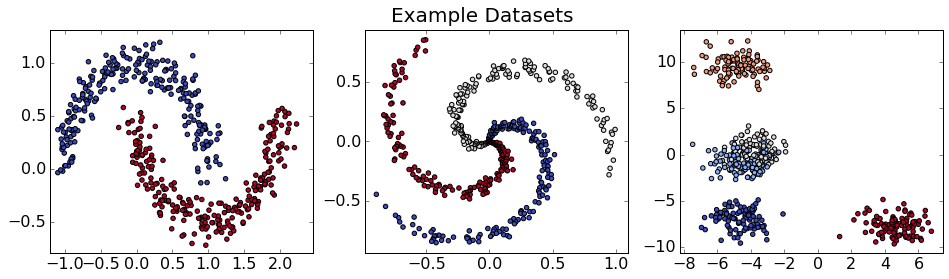

In [61]:
from matplotlib import pyplot as plt
import matplotlib
import sklearn.datasets

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

class ToyDataset:

    def __init__(self, size, features, classes, type='spirals',
                 train_ratio=0.75, noise=0.15, rand_seed=1337):
        """
        Toy dataset generator for multi-label classification.

        Arguments:
            size        -- number of examples
            features    -- input dimensions
            classes     -- number of classes (labels)
            type        -- which generator to use
            train_ratio -- train/test split ratio
            noise       -- random noise parameter
        """
        np.random.seed(rand_seed)
        if type == 'moons':
            x, y = sklearn.datasets.make_moons(n_samples=size, noise=noise)
        elif type == 'blobs':
            x, y = sklearn.datasets.make_blobs(n_samples=size, centers=classes,
                                               n_features=features)
        elif type == 'spirals':
            per_class = size // classes
            x = np.zeros((per_class * classes, features))
            y = np.zeros(per_class * classes, dtype='i')
            for j in range(classes):
                ix = range(per_class * j, per_class * (j + 1))
                r = np.linspace(0.0, 1, per_class)
                t = (np.linspace(j * 4, (j + 1) * 4, per_class) +
                     np.random.randn(per_class) * noise)
                x[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
                y[ix] = j
        else:
            raise NotImplementedError()

        # Turn y into array of one-hot vectors
        y_hot = np.zeros((y.shape[0], classes))
        y_hot[np.arange(y.shape[0]), y] = 1.0

        # Test/train split
        mask = np.random.rand(y.shape[0]) <= train_ratio
        self.x_train, self.y_train = x[mask], y_hot[mask]
        self.x_test, self.y_test = x[~mask], y_hot[~mask]
        self.x, self.y = x, y_hot
        
    def plot(self):
        plt.scatter(self.x[:, 0], self.x[:, 1],
                    c=np.argmax(self.y, axis=1),
                    cmap=plt.cm.coolwarm)
        plt.xlim(np.min(self.x[:, 0])*1.1, np.max(self.x[:, 0])*1.1)
        plt.ylim(np.min(self.x[:, 1])*1.1, np.max(self.x[:, 1])*1.1)


# Plot a few example toy datasets
plt.figure(figsize=(16,4)).suptitle('Example Datasets', fontsize=20)
plt.subplot(131)
ToyDataset(500, 2, 2, type='moons', noise=0.1).plot()
plt.subplot(132)
ToyDataset(500, 2, 3, type='spirals').plot()
plt.subplot(133)
ToyDataset(500, 2, 5, type='blobs').plot()


### Visualization

In [59]:
def plot(model, ds, history, title=None):
    """
    Plot contour of model prediction and train/test loss
    history side by side.
    """
    _, predict, _ = model
    fig = plt.figure(figsize=(15, 5))
    if title:
        fig.suptitle(title)

    def contour():
        xmin, xmax = ds.x[:, 0].min(), ds.x[:, 0].max()
        ymin, ymax = ds.x[:, 1].min(), ds.x[:, 1].max()
        cx = np.arange(xmin * 1.1, xmax * 1.1, (xmax - xmin) / 100)
        cy = np.arange(ymin * 1.1, ymax * 1.1, (ymax - ymin) / 100)
        points = [[px, py] for py in cy for px in cx]
        z = np.argmax(predict(points), axis=1).reshape((len(cy), len(cx)))
        plt.contourf(cx, cy, z, cmap=plt.cm.coolwarm, alpha=0.75)
        plt.scatter(ds.x[:, 0], ds.x[:, 1], c=np.argmax(ds.y, axis=1),
                    cmap=plt.cm.coolwarm)

    # Plot model predictions contour
    plt.subplot(1, 2, 1)
    contour()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot([epoch for (epoch, _, _) in history],
             [(train, test) for (_, train, test) in history])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


def train_and_plot(model, ds, title, **kwargs):
    history = train(model, ds, **kwargs)
    plot(model, ds, history, title)

### Run models on toy datasets and plot results

Epoch 200: train loss 0.1228, test loss 0.1479
Epoch 400: train loss 0.1138, test loss 0.1414
Epoch 600: train loss 0.0058, test loss 0.0074
Epoch 800: train loss 0.0027, test loss 0.0037
Epoch 1000: train loss 0.0018, test loss 0.0041
Epoch 200: train loss 0.0259, test loss 0.0293
Epoch 400: train loss 0.0091, test loss 0.0110
Epoch 600: train loss 0.0055, test loss 0.0081
Epoch 800: train loss 0.0039, test loss 0.0101
Epoch 1000: train loss 0.0031, test loss 0.0064


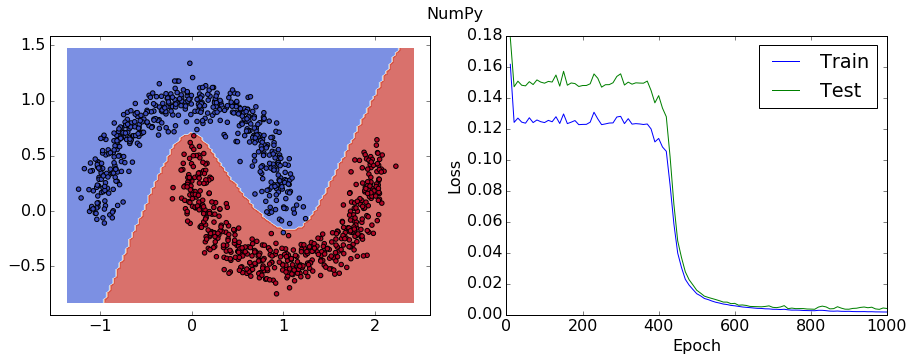

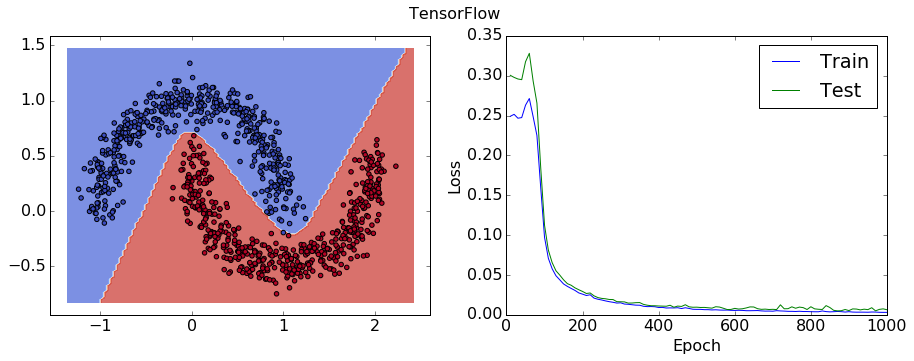

In [9]:
ds = ToyDataset(1000, 2, 2, type='moons', noise=0.1)
train_and_plot(numpy_classifier(2, 2, 16), ds, "NumPy")
train_and_plot(tensorflow_classifier(2, 2, 16), ds, "TensorFlow")

Epoch 200: train loss 0.0827, test loss 0.0879
Epoch 400: train loss 0.0388, test loss 0.0457
Epoch 600: train loss 0.0289, test loss 0.0385
Epoch 800: train loss 0.0228, test loss 0.0289
Epoch 1000: train loss 0.0207, test loss 0.0275
Epoch 200: train loss 0.1969, test loss 0.2287
Epoch 400: train loss 0.1282, test loss 0.1514
Epoch 600: train loss 0.0985, test loss 0.1160
Epoch 800: train loss 0.1029, test loss 0.1225
Epoch 1000: train loss 0.0795, test loss 0.1048


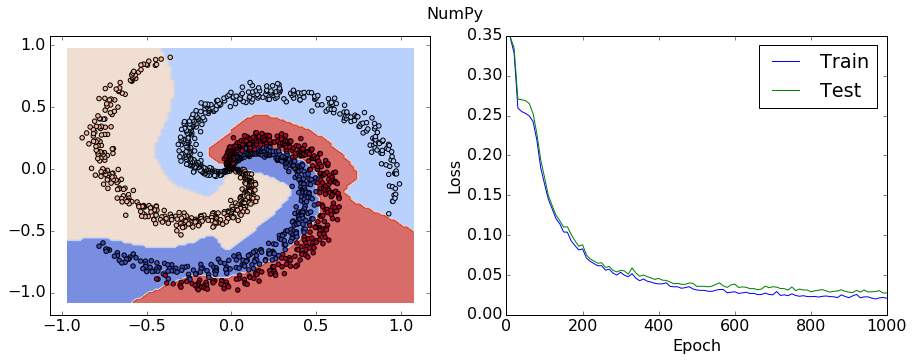

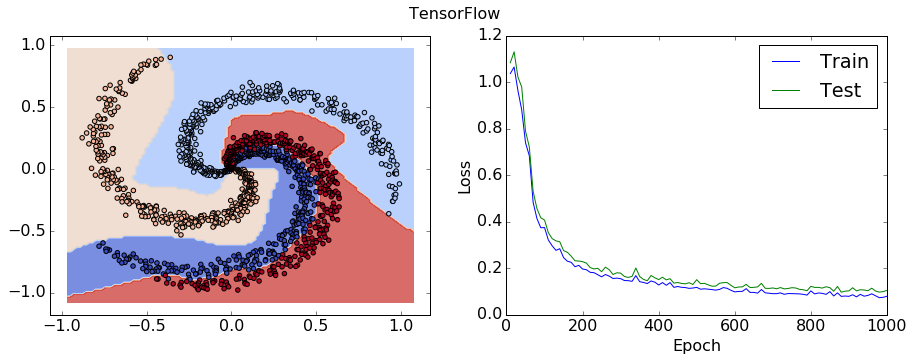

In [53]:
ds = ToyDataset(1500, 2, 4, type='spirals', noise=0.15)
train_and_plot(numpy_classifier(2, 4, 32), ds, "NumPy")
train_and_plot(tensorflow_classifier(2, 4, 32), ds, "TensorFlow")

Epoch 200: train loss 0.0385, test loss 0.0374
Epoch 400: train loss 0.0366, test loss 0.0351
Epoch 600: train loss 0.0415, test loss 0.0327
Epoch 800: train loss 0.0365, test loss 0.0332
Epoch 1000: train loss 0.0369, test loss 0.0306
Epoch 200: train loss 0.2659, test loss 0.2720
Epoch 400: train loss 0.1884, test loss 0.1585
Epoch 600: train loss 0.1825, test loss 0.1621
Epoch 800: train loss 0.1830, test loss 0.1502
Epoch 1000: train loss 0.1878, test loss 0.1784


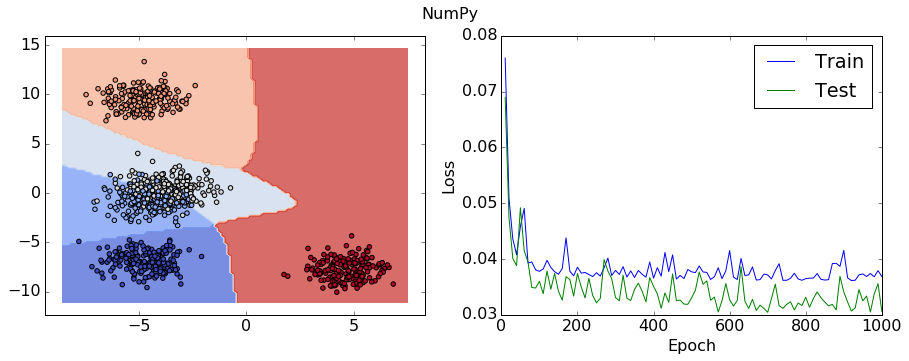

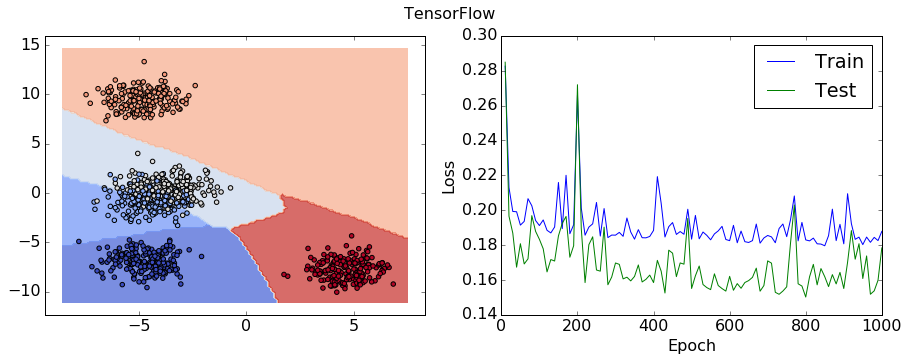

In [49]:
ds = ToyDataset(1000, 2, 5, type='blobs')
train_and_plot(numpy_classifier(2, 5, 10), ds, "NumPy")
train_and_plot(tensorflow_classifier(2, 5, 10), ds, "TensorFlow")

### Solve MNIST

Run our model on the MNIST dataset of handwritten digits. While this isn't the best approach to solve MNIST (there are [better models](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)), it should make for a decent baseline.

In [67]:
from tensorflow.examples.tutorials.mnist import input_data

class MNISTDataset:
    """
    Adapter for TensorFlow's built-in MNIST dataset.
    """
    def __init__(self, mnist):
        self.x_train = mnist.train.images
        self.y_train = mnist.train.labels
        self.x_test = mnist.test.images
        self.y_test = mnist.test.labels

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist_ds = MNISTDataset(mnist)

# MNIST images have 784 pixels and map to 10 possible classes (digits)
model = numpy_classifier(784, 10, 64)
train(model, mnist_ds, batch_size=100, epochs=40, num_reports=40)

# Compute precision on validation dataset
_, predict, _ = model
predicted = np.argmax(predict(mnist.validation.images), axis=1)
actual = np.argmax(mnist.validation.labels, axis=1)
avg_prec = np.average((predicted == actual) * 1.0)
print("Avg. precision: {:.2f}%".format(avg_prec * 100))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 20: train loss 0.0094, test loss 0.0113
Epoch 40: train loss 0.0050, test loss 0.0089
Epoch 60: train loss 0.0031, test loss 0.0085
Epoch 80: train loss 0.0021, test loss 0.0086
Epoch 100: train loss 0.0015, test loss 0.0088
Avg. precision: 97.34%


FYI the best models achieve **~99.8%** accuracy on this dataset.